In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
# Reading in the data
df = pd.read_csv("beer_profile_and_ratings.csv")

[]

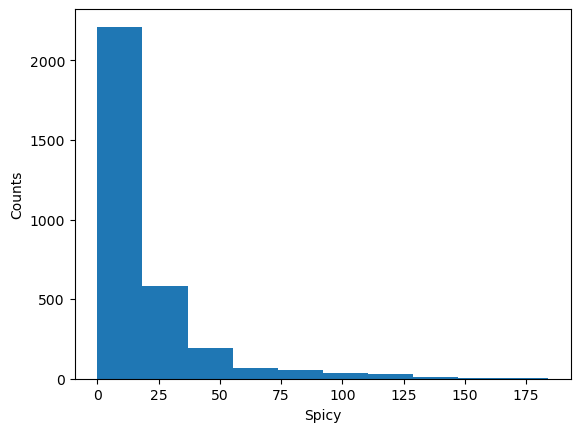

In [2]:
plt.hist(df['Spices'])
plt.xlabel('Spicy')
plt.ylabel('Counts')
plt.plot()

In [3]:
# Drop the beers having less than 50 reviews
df.drop(df[df['number_of_reviews'] < 50].index, inplace = True)
df.reset_index(inplace = True, drop = True)

# Create the new, categorical columns (before deleting the old ones)
# All the columns are gonna be deleted, except ABV and review_overall
all_features = list(df.columns)
all_features.remove('review_overall')
all_features.remove('ABV')
categorical_columns = ['Astringency', 'Body', 'Bitter', 'Sweet', 'Sour', 'Fruits', 'Spices']

labels = [0, 1, 2, 3]
for i in range(len(categorical_columns)):
    column = categorical_columns[i]
    
    # Here, we're trying to split the data into bins of +/- equal size
    # However, since some values appear more than 1/5 of the time (as for example salty appears 1527 with value 0)
    # There's no solution but to increase the lower bound of the next interval (and all the ones following)
    theSplit = np.array_split(np.sort(df[column]), 4)
    intervals = list(map(lambda x: x[0], theSplit))
    for i in range(1, len(intervals)):
        if intervals[i] <= intervals[i - 1]:
            intervals[i] = intervals[i - 1] + 1
    intervals.append(theSplit[-1][-1])
    
    categorized = pd.cut(df[column], bins = intervals, labels = labels, include_lowest = True)
    df.insert(i + 2, column.lower(), categorized)

# Drop the unnecessary/useless columns
df.drop(all_features, axis = 1, inplace = True)
df.shape

(1990, 9)

In [4]:
# the manually selected interval bounds
# high-quality beers are the ones with >=4.5 rating
intervals = [1, 3.5, 4, 4.5, 5]

# creating the features and labels 
X = df.drop(['review_overall'], axis = 1)
y = pd.cut(df['review_overall'], bins = intervals, labels = labels, include_lowest = True)
y.value_counts()

review_overall
1    1067
2     572
0     335
3      16
Name: count, dtype: int64

In [5]:
# splitting data into train/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.3, random_state = 127)
stratKFold = StratifiedKFold(shuffle = True)

# lists to save the train accuracies, validation accuracies, and the models themselves
y_train_acc_rfc = []
y_valid_acc_rfc = []
rfcs = []

for tr, val in stratKFold.split(X_train_val, y_train_val):
    X_train = X_train_val.iloc[tr] 
    X_val = X_train_val.iloc[val]
    y_train = y_train_val.iloc[tr]
    y_val = y_train_val.iloc[val]
    
    # creating and training the model
    rfc = RandomForestClassifier(criterion = 'entropy', min_samples_split = 10)
    rfc.fit(X_train, y_train)
    
    y_train_acc_rfc.append(accuracy_score(rfc.predict(X_train), y_train))
    y_valid_acc_rfc.append(accuracy_score(rfc.predict(X_val), y_val))
    rfcs.append(rfc)
    
bestRFCval = rfcs[np.argmax(y_valid_acc_rfc)]
bestRFCtrain = rfcs[np.argmax(y_train_acc_rfc)]
print(f"The best train accuracy is achieved during fold {1 + np.argmax(y_train_acc_rfc)} and it is equal to {max(y_train_acc_rfc)}.")
print(f"The best validation accuracy is achieved during fold {1 + np.argmax(y_valid_acc_rfc)} and it is equal to {max(y_valid_acc_rfc)}.")
print(f"The test accuracy of the best train model is {accuracy_score(y_test, bestRFCtrain.predict(X_test))}.")
print(f"The test accuracy of the best validation model is {accuracy_score(y_test, bestRFCval.predict(X_test))}.")

The best train accuracy is achieved during fold 2 and it is equal to 0.803411131059246.
The best validation accuracy is achieved during fold 5 and it is equal to 0.6330935251798561.
The test accuracy of the best train model is 0.6381909547738693.
The test accuracy of the best validation model is 0.6381909547738693.


Text(0.5, 1.0, 'Confusion Matrix')

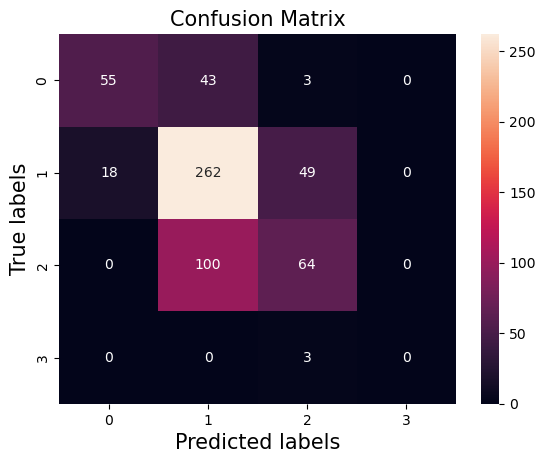

In [6]:
ax= plt.subplot()

sns.heatmap(confusion_matrix(y_test, bestRFCval.predict(X_test)), annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)